# 1. Data wrangling and preprocessing

In [207]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# data augmentation
import imgaug.augmenters as iaa

from sklearn.model_selection import train_test_split

## 1.1. Data loading

Load the satellite images and their corresponding boundary labels into memory.

⚠️ Choose root_path accordingly [set as google drive path, because of colab implementation].  
⚠️ Remember to pair the images and labels appropriately. Here we use a simple sort.

In [208]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [209]:
root_dir = './drive/MyDrive' # '../' on your laptop

In [210]:
# Define paths to training images/labels and test images
train_images_dir = root_dir + '/data/raw/train_images'
train_labels_dir = root_dir + '/data/raw/train_labels'
test_images_dir = root_dir + '/data/raw/test_images'

# Load training images and labels
train_images = []
train_labels = []

# sorting input directory to correctly pair training image/label
for filename in sorted(os.listdir(train_images_dir)):
    if filename.endswith('.png'):
        image = cv2.imread(os.path.join(train_images_dir, filename))
        train_images.append(image)

for filename in sorted(os.listdir(train_labels_dir)):
    if filename.endswith('.png'):
        label = cv2.imread(os.path.join(train_labels_dir, filename), cv2.IMREAD_GRAYSCALE)
        train_labels.append(label)

# Load test images
test_images = []
for filename in sorted(os.listdir(test_images_dir)):
    if filename.endswith('.png'):
        image = cv2.imread(os.path.join(test_images_dir, filename))
        test_images.append(image)

## 1.2. Data Exploration

### 1.2.1 Visualising the data

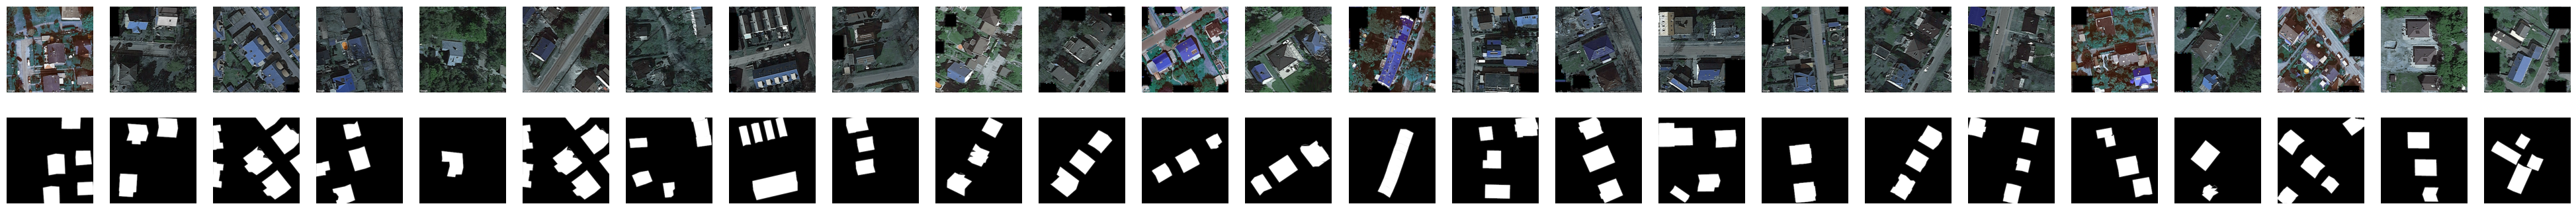

In [211]:
# Diplay training images/labels
fig, ax = plt.subplots(ncols=25, nrows=2, figsize=(50,4))

for idx in range(len(train_images)):

  ax[0, idx].imshow(train_images[idx])
  ax[1, idx].imshow(train_labels[idx], cmap='gray')

  ax[0, idx].axis('off')
  ax[1, idx].axis('off')

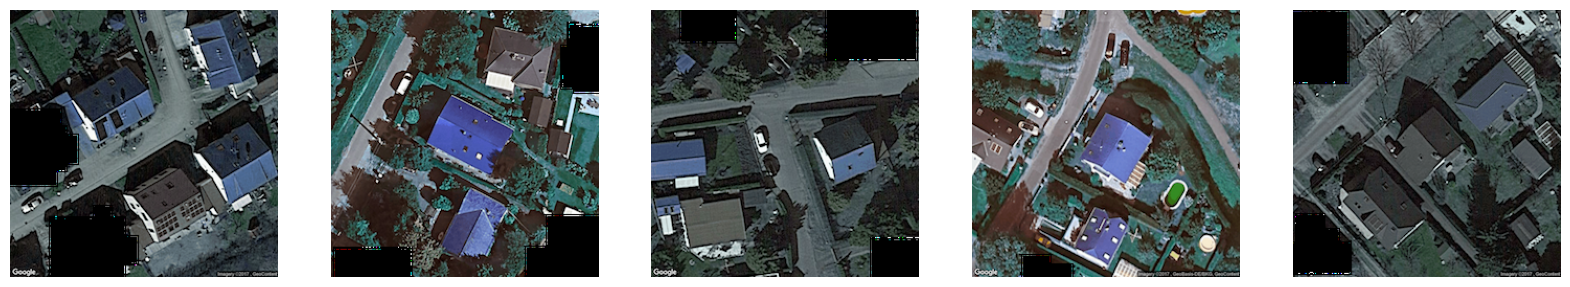

In [212]:
# Display test images
fig, ax = plt.subplots(ncols=5, figsize=(20,4))

for idx in range(len(test_images)):

  ax[idx].imshow(test_images[idx])
  ax[idx].axis('off')

The visualisation confirms that the images/labels have been correctly paired.

🚨 But it also shows that some images have black-spots [might indicate corruption].

**Examples of Corrupted images**

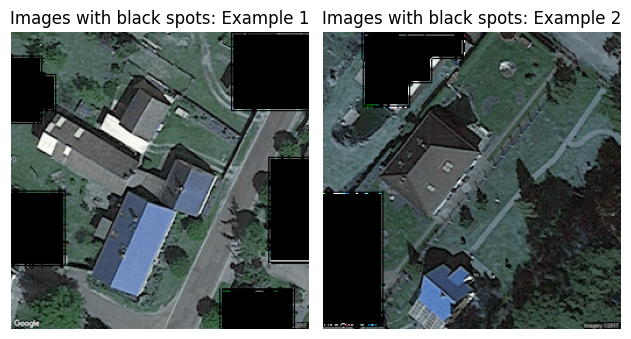

In [213]:
# Training image
plt.subplot(1, 2, 1)
plt.imshow(train_images[-1])
plt.title('Images with black spots: Example 1')
plt.axis('off')

# Training label
plt.subplot(1, 2, 2)
plt.imshow(train_images[-4])
plt.title('Images with black spots: Example 2')
plt.axis('off')

plt.tight_layout()
plt.show()


### 1.2.2. Data distribution

Examine the distribution of the roof boundary masks in the training set. We count the number of positive and negative samples to ensure a balanced dataset.

In [214]:
# Count the average number of positive and negative samples in the boundary
# masks across all the labels in the training set
def count_samples(masks):

    num_positive = np.average([np.sum(masks[idx] > 0) for idx in range(len(masks))])
    num_negative = np.average([np.sum(masks[idx] == 0) for idx in range(len(masks))])
    return num_positive, num_negative

# Call the count_samples function with your boundary masks
num_positive_samples, num_negative_samples = count_samples(train_labels)
print('Averaged across training set:')
print("Positive samples: ", num_positive_samples)
print("Negative samples: ", num_negative_samples)

Averaged across training set:
Positive samples:  10890.24
Negative samples:  54645.76


The numbers of positive samples roughly number 1:5 for every negative cell. This is an imbalanced set, but is not a case of extreme imbalance. We put a warning here to look into this later and move on. ⚠️

## 1.3. Data Preprocessing

### 1.3.1. Resizing images to a consistent resolution

This step is not necessary. All our images are already in a (256 x 256) shape.

In [215]:
# Run this code to ensure that all images are (256x256)
'''
for index in range(len(train_images)):

    # Get the resolution of the image
    height, width, channels = train_images[index].shape

    print(f"Image Resolution: {width}x{height}. Numer of Channels: {channels}")

for index in range(len(train_labels)):

    # Get the resolution of the image
    height, width = train_labels[index].shape

    print(f"Image Resolution: {width}x{height}.")

for index in range(len(test_images)):

    # Get the resolution of the image
    height, width, channels = test_images[index].shape

    print(f"Image Resolution: {width}x{height}. Numer of Channels: {channels}")
'''

# Otherwise, use following code to resize to (256x256)

'''
# Resize images to a consistent resolution
target_resolution = (256, 256)  # Adjust to desired resolution

def resize_image(image, resolution):
    return cv2.resize(image, resolution)

train_images = [resize_image(image, target_resolution) for image in train_images]
train_labels = [resize_image(label, target_resolution) for label in train_labels]
test_images = [resize_image(image, target_resolution) for image in test_images]
'''

'\n# Resize images to a consistent resolution\ntarget_resolution = (256, 256)  # Adjust to desired resolution\n\ndef resize_image(image, resolution):\n    return cv2.resize(image, resolution)\n\ntrain_images = [resize_image(image, target_resolution) for image in train_images]\ntrain_labels = [resize_image(label, target_resolution) for label in train_labels]\ntest_images = [resize_image(image, target_resolution) for image in test_images]\n'

### 1.3.2. Normalise Pixel values

In [216]:
# Normalize pixel values
train_images = np.array(train_images) / 255.0
train_labels = np.array(train_labels) / 255.0
test_images = np.array(test_images) / 255.0

### 1.2.3. Data augmentation

This step is important since we have only 25 training samples. This will increase the training size and improve generalisation. The augmentation techniques we use here are:
* Flip horizontally with a 50% chance
* Rotate image by -20 to 20 degrees
* Scale image by 0.8 to 1.2
* Translate image by -20% to 20% on each axis
* Shear image by -20 to 20 degrees
* Zoom image by 0.8 to 1.2 on each axis

🚨WARNING: Make sure to apply the augmentation identically to the image and the segmentation map.

For every image/segmentation map pair, we make 5 additional data augmented versions.

In [217]:
# Apply techniques like rotation, flipping, scaling, etc. to increase training data size
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip horizontally with a 50% chance
    iaa.Affine(rotate=(-20, 20)),  # Rotate image by -20 to 20 degrees
    iaa.Affine(scale=(0.8, 1.2)),  # Scale image by 0.8 to 1.2
    iaa.Affine(translate_percent=(-0.2, 0.2)),  # Translate image by -20% to 20% on each axis
    iaa.Affine(shear=(-20, 20)),  # Shear image by -20 to 20 degrees
    iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),  # Zoom image by 0.8 to 1.2 on each axis
])

# Apply transformations identically to image and map
# Make 5 augmentations for each image/map pair

augmented_train_images = []
augmented_train_labels = []

for idx in range(len(train_images)):
    image = train_images[idx]
    segmap = SegmentationMapsOnImage(train_labels[idx], shape=train_labels[idx].shape)

    for _ in range(5):
        images_aug_i, segmaps_aug_i = augmenter(image=image, segmentation_maps=segmap)
        augmented_train_images.append(images_aug_i)
        augmented_train_labels.append(segmaps_aug_i.arr)

# Combine with original dataset of 25 images
train_images = np.concatenate([train_images, augmented_train_images])
train_labels = np.concatenate([train_labels, np.squeeze(augmented_train_labels)])

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


How big have we made our training set? 150
Some examples:


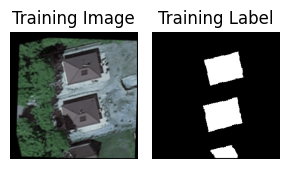

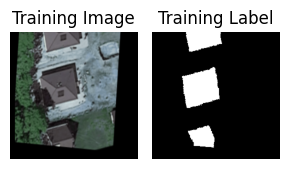

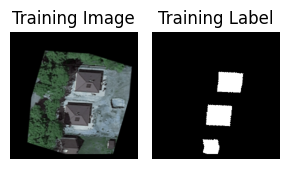

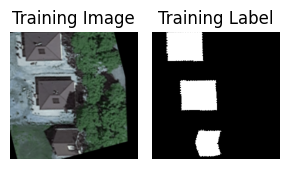

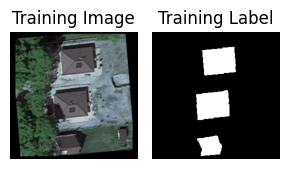

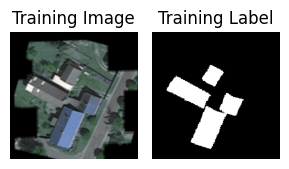

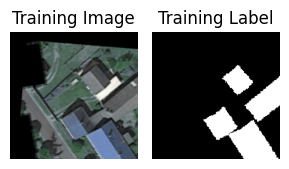

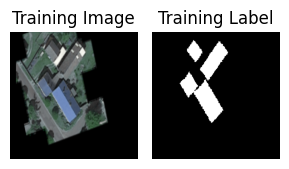

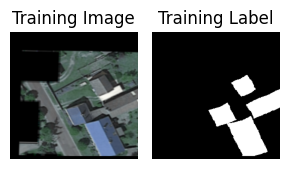

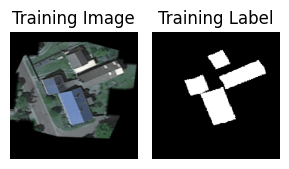

In [218]:
print(f"How big have we made our training set? {len(train_images)}")
print("Some examples:")

# Display some random examples from the augmented set, to ensure
# augmentation has been performed, and that it has been performed
# identically to image/map pair
for index in range(len(augmented_train_images))[-10:]:

    plt.figure(figsize=(3,2))
    # Training image
    plt.subplot(1, 2, 1)
    plt.imshow(augmented_train_images[index])
    plt.title('Training Image')
    plt.axis('off')

    # Training label
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_train_labels[index], cmap='gray')
    plt.title('Training Label')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## 1.4. Train-validation split

We make a 70-30 split between our training and validation sets.

⚠️ We decreased this from 80-20, because the validation set was too small for a reasonable prediction.

⚠️ The validation set thus defined is used for the model evaluation. This is an important point to keep in mind, because, the U-Net model we use below has, as one of its options, `validation_split`, which is the portion of the training data that would be used for the validation of the training. The `(val_images, val_labels)` we set aside for model evaluation.

In [219]:
# Split training data into training and validation subsets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.3, random_state=42)

**Save (re-scaled) preprocessed data**

The rescaling is needed to save the data. See reason [here](https://stackoverflow.com/a/54165573).

In [220]:
# Save preprocessed training images and labels
train_output_dir = root_dir + '/data/preprocessed/train'
os.makedirs(train_output_dir, exist_ok=True)

for i, image in enumerate(train_images):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    cv2.imwrite(os.path.join(train_output_dir, image_filename), 255*image)

for i, label in enumerate(train_labels):
    label_filename = f"rescaled_preprocessed_label_{i}.png"
    cv2.imwrite(os.path.join(train_output_dir, label_filename), 255*label)

# Save preprocessed validation images and labels
val_output_dir = root_dir + '/data/preprocessed/valid'
os.makedirs(val_output_dir, exist_ok=True)

for i, image in enumerate(val_images):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    cv2.imwrite(os.path.join(val_output_dir, image_filename), 255*image)

for i, label in enumerate(val_labels):
    label_filename = f"rescaled_preprocessed_label_{i}.png"
    cv2.imwrite(os.path.join(val_output_dir, label_filename), 255*label)

# Save preprocessed test images
test_output_dir = root_dir + '/data/preprocessed/test'
os.makedirs(test_output_dir, exist_ok=True)

for i, image in enumerate(test_images):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    cv2.imwrite(os.path.join(test_output_dir, image_filename), 255*image)


# 2. Modelling

In [221]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

## 2.0. Uploaded (rescaled) preprocessed images/labels and renormalise them

🚨 Section 2. can be run independently of Section 1. Please uncomment the code block below to start from here.

In [222]:
root_dir = './drive/MyDrive' # '../' on your laptop

In [223]:
# Load preprocessed training images and labels
train_input_dir = root_dir + '/data/preprocessed/train'

train_images = []
train_labels = []

for i in range(int(len(os.listdir(train_input_dir))/2)):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(train_input_dir, image_filename)
    image = cv2.imread(image_path)
    train_images.append(image)

    label_filename = f"rescaled_preprocessed_label_{i}.png"
    label_path = os.path.join(train_input_dir, label_filename)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    train_labels.append(label)

# Load preprocessed validation images and labels
val_input_dir = root_dir + '/data/preprocessed/valid'

val_images = []
val_labels = []

for i in range(int(len(os.listdir(val_input_dir))/2)):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(val_input_dir, image_filename)
    image = cv2.imread(image_path)
    val_images.append(image)

    label_filename = f"rescaled_preprocessed_label_{i}.png"
    label_path = os.path.join(val_input_dir, label_filename)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    val_labels.append(label)

# Load preprocessed test images
test_input_dir = root_dir + '/data/preprocessed/test'

test_images = []

for i in range(5):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(test_input_dir, image_filename)
    image = cv2.imread(image_path)
    test_images.append(image)

In [224]:
# Normalize pixel values
train_images = np.array(train_images) / 255.0
train_labels = np.array(train_labels) / 255.0

val_images = np.array(val_images) / 255.0
val_labels = np.array(val_labels) / 255.0

test_images = np.array(test_images) / 255.0

## 2.1 Network Architecture

U-Net, CNN architechture suitable for image segmentation task; takes satellite image as input and generates binary mask where the roofs' boundaries are represented as white pixels (255) and the rest of the image as black (0).

⚠️ Provide more details

In [225]:
from tensorflow.keras import layers

def unet():
    inputs = keras.Input(shape=(None, None, 3))

    # Contracting Path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Expansive Path
    up1 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    up1 = layers.concatenate([up1, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up2 = layers.concatenate([up2, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up3 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up3 = layers.concatenate([up3, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    return keras.Model(inputs=inputs, outputs=outputs)


## 2.2. Model training

### 2.2.1 Model Details

In [226]:
optimizer = 'adam' # good for boundary detection; other options: RMSprop, SGD
loss = 'binary_crossentropy'
metrics = ['binary_accuracy'] # other options: binary_crossentropy

In [227]:
model = unet()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_285 (Conv2D)            (None, None, None,   1792        ['input_20[0][0]']               
                                64)                                                               
                                                                                                  
 conv2d_286 (Conv2D)            (None, None, None,   36928       ['conv2d_285[0][0]']             
                                64)                                                        

2.2.2 Training Details

In [228]:
batch_size = 32 # increased in powers of 2, from 8, until statistical fluctuations between epochs stabilised
epochs = 100 # increased from 20, until the model showed signs of overfitting (train/valid curves started diverging)
validation_split = 0.3

In [229]:
# Assuming you have loaded your training data into `train_images` and `train_masks` arrays
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/100
3/3 [==============================] - 10s 1s/step - loss: 0.6664 - binary_accuracy: 0.6336 - val_loss: 0.5637 - val_binary_accuracy: 0.8736
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.5369 - binary_accuracy: 0.8789 - val_loss: 0.5091 - val_binary_accuracy: 0.8736
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.4927 - binary_accuracy: 0.8789 - val_loss: 0.4480 - val_binary_accuracy: 0.8736
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 0.4048 - binary_accuracy: 0.8789 - val_loss: 0.3472 - val_binary_accuracy: 0.8736
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 0.3513 - binary_accuracy: 0.8789 - val_loss: 0.3773 - val_binary_accuracy: 0.8736
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.3537 - binary_accuracy: 0.8789 - val_loss: 0.3360 - val_binary_accuracy: 0.8736
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.3311 - binary_a

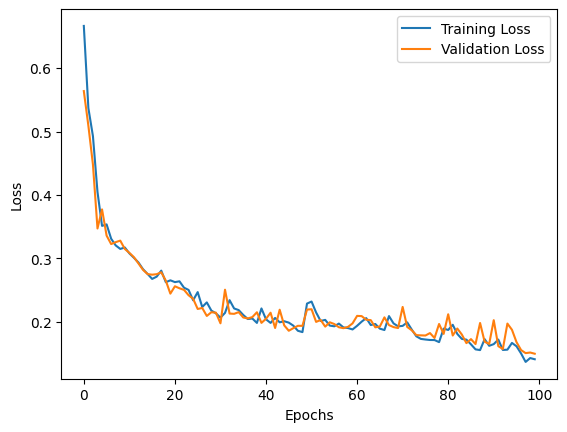

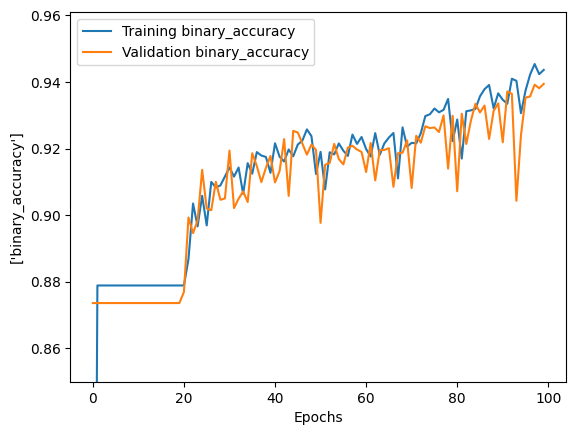

In [230]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure()
for metric in metrics:
  train_metrics = history.history[f'{metric}']
  val_metrics = history.history[f'val_{metric}']

  # Plotting the Metrics curve
  plt.plot(train_metrics, label=f'Training {metrics[0]}')
  plt.plot(val_metrics, label=f'Validation {metrics[0]}')
  plt.xlabel('Epochs')
  plt.ylabel(f'{metrics}')
  plt.legend()

plt.ylim(bottom=0.85)
plt.show()

## 2.3. Model Evaluation

In [231]:
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

2/2 [==============================] - 1s 170ms/step - loss: 0.1360 - binary_accuracy: 0.9439
Validation Loss: 0.1360
Validation Accuracy: 0.9439


## 2.4. Testing

Applying trained model to the test set.

In [232]:
predictions = model.predict(test_images)

1/1 [==============================] - 0s 304ms/step


**Example prediction:** The model predicts a non-binary segmentation of the roofs from the satellite images. In order to convert them to the binary masks, that our original training labels indicated, we need to perform some postprocessing.

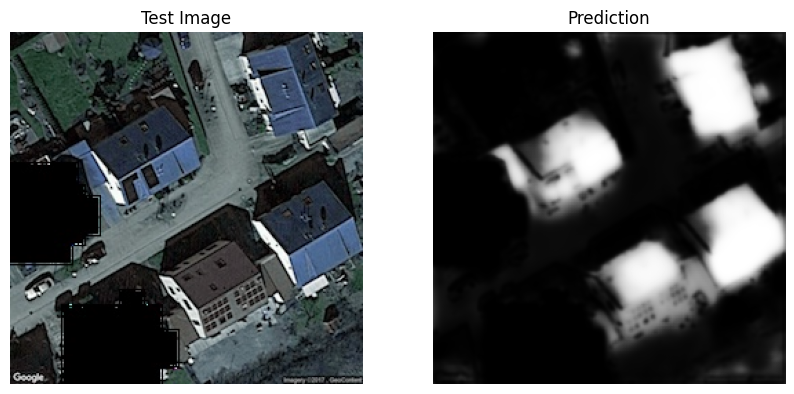

In [233]:
i = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display test image
axes[0].imshow(test_images[i])
axes[0].set_title('Test Image')
axes[0].axis('off')

# Display prediction
axes[1].imshow(predictions[i], cmap='gray')
axes[1].set_title('Prediction')
axes[1].axis('off')

plt.show()

## 2.5. Postprocessing

In [234]:
# Apply thresholding to convert predicted masks to binary images
def post_process(predictions, threshold=0.5):
    binary_images = (predictions > threshold).astype(np.uint8)
    return binary_images

processed_predictions = post_process(predictions, threshold=0.5)

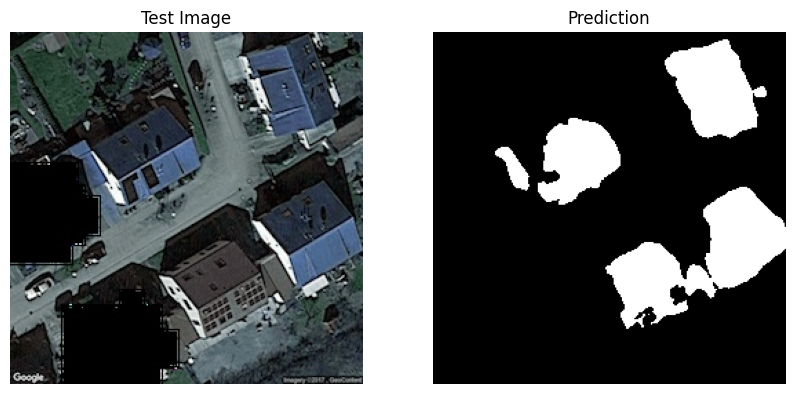

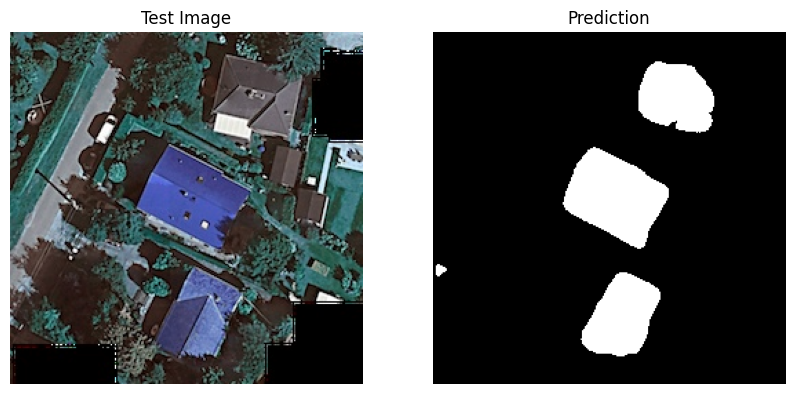

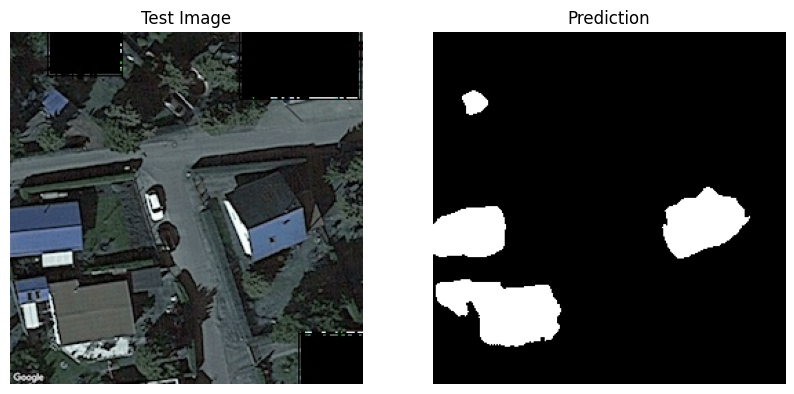

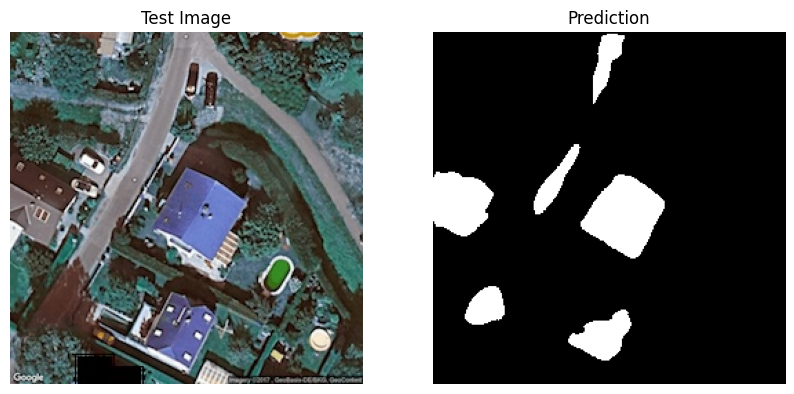

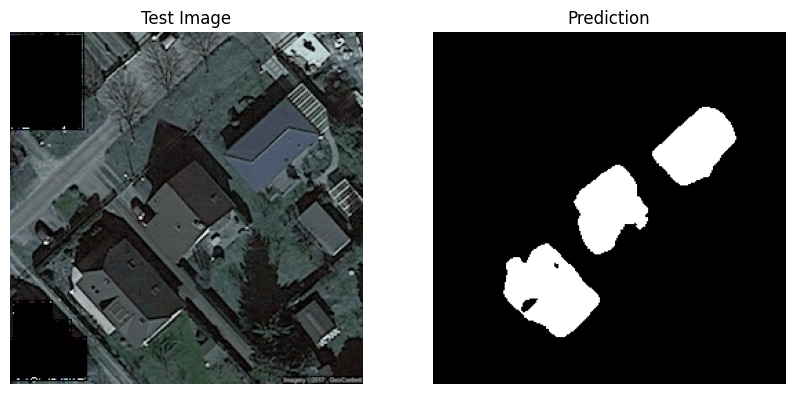

In [235]:
for i in range(len(test_images)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display test image
    axes[0].imshow(test_images[i])
    axes[0].set_title('Test Image')
    axes[0].axis('off')

    # Display prediction
    axes[1].imshow(processed_predictions[i], cmap='gray')
    axes[1].set_title('Prediction')
    axes[1].axis('off')

    plt.show()

## 2.6. Saving Predictions and Model

In [236]:
# Save test images and predicted labels
test_output_dir = root_dir + '/data/predictions'
os.makedirs(test_output_dir, exist_ok=True)

for i, image in enumerate(test_images):
    image_filename = f"test_image_{i}.jpg"
    cv2.imwrite(os.path.join(test_output_dir, image_filename), 255*image)

for i, label in enumerate(processed_predictions):
    label_filename = f"test_label_{i}.png"
    cv2.imwrite(os.path.join(test_output_dir, label_filename), 255*label)


In [237]:
# Save the entire model
model.save(root_dir + '/models/unet_final.h5')

# Load the saved model
#from tensorflow.keras.models import load_model
#model = load_model("../models/baseline.h5")